In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import requests
from country_dict import top_100_gdp_countries
from IPython.display import clear_output
from thefuzz import process

format = True
if format:
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)         
    pd.set_option('display.max_colwidth', None)  
    pd.set_option('display.max_rows', None)

In [3]:
class WorldBank:
    def __init__(self):
        """
        Initializes the WorldBank class.

        Sets up attributes for storing:
        - Codes of interest
        - Main data frame
        - Indicator metadata from the 'WDI series' sheet in the Excel file
        - Currently selected indicator code and description
        """
        
        self.codes_of_interest = None
        self.data = None
        self.indicator_sheet = pd.read_excel('WDI_CETS.xls', sheet_name='WDI series')
        self.ind_code = None
        self.code_desc = None
    

    def get_data_api(self, country_name, ind_code, testing=None):
        """
        Fetches data from the World Bank API for a given country and indicator code.

        Args:
            country_name (str): Name of the country.
            ind_code (str): Indicator code to fetch.
            testing (bool, optional): If True, returns True for test validation. Defaults to False.

        Returns:
            pd.DataFrame or bool: A DataFrame with 'year' as index and 'value' as the column if data exists;
            otherwise, returns False.
        """
                
        # Define parameters
        country_code = top_100_gdp_countries[country_name]


        url = f'http://api.worldbank.org/v2/country/{country_code}/indicator/{ind_code}?format=json&per_page=1000'

        # Fetch data
        response = requests.get(url)
        data = response.json()

        # Convert to DataFrame
        if isinstance(data, list) and len(data) > 1:
            records = data[1]  # Data is in the second item of the list
            df = pd.DataFrame(records)

            # cleaning up the data
            df = df[['date', 'value']].dropna().sort_values('date').rename(columns={'date': 'year'})
            df = df.apply(pd.to_numeric, errors='coerce')
            df['year'] = df['year'].astype(int)
            df = df.set_index('year')

            # interpolating missing 
            df['value'] = df['value'].interpolate(method='linear')

            if testing:
                return True
                    
            else:
                return df
                
        else:
            return False


    def import_from_world_bank(self, country_name, ind_code=None, whole=None):
        """
        Imports World Bank data either for a specific indicator or the entire dataset for a given country.

        This method uses local CSV files or the World Bank API depending on parameters. 
        It supports fuzzy matching of country names to improve usability.

        Args:
            country_name (str or list of str): The name of the country or a list of country names.
            ind_code (str, optional): The specific indicator code to import data for. Required when using multiple countries.
            whole (bool, optional): If True, imports the entire dataset for a single country from a local file.

        Raises:
            ValueError: If a list of countries is passed when `whole=True`.
            KeyError: If the country name is not found in the internal data dictionary and cannot be matched.

        Updates:
            self.data (pd.DataFrame): The imported dataset for the specified country or indicator.
            self.ind_code (str): The selected indicator code, if provided.
        """

        country_data_dict = {
                            'Panama': 'Panama_Data/API_PAN_DS2_en_csv_v2_25144.csv',
                            'Norway': 'Norway_Data/API_NOR_DS2_en_csv_v2_16152.csv',
                            'South Korea': 'Korea_Data/API_KOR_DS2_en_csv_v2_15934.csv'
                            }
        
        # list of top 100 GDP countries
        available_countries = top_100_gdp_countries.keys()
        

        def fuzzy_match_country(country_name, available_countries):
            """
            Attempts to fuzzy match a given country name to a list of available countries.

            If the provided country name is not found directly in the list of available countries,
            fuzzy string matching is used to find the closest match. If a match score is between
            80 and 89, the user is prompted to confirm the suggestion.

            Args:
                country_name (str): The name of the country to match.
                available_countries (Iterable[str]): A list or other iterable of valid country names.

            Returns:
                str or None: The matched country name if a match is confirmed or strong enough.
                Returns None if the user rejects the suggestion or no good match is found.

            Side Effects:
                Prompts user input via console if the match score is between 80 and 89.
            """

            if country_name not in available_countries:

                best_match, score = process.extractOne(country_name, available_countries)
                
                if score >= 90:
                    country_name = best_match
            
                elif score >= 80:
                    response = input(f'Did you mean \'{best_match}\'? (y/n)')

                    if response in ['Yes', 'yes', 'Y', 'y']:
                        country_name = best_match
                        return country_name
                            
                    else:
                        print(f'\'{country_name}\' not found, try again.')
            
            else:
                return country_name

        

        if isinstance(country_name, list):
            country_name = [fuzzy_match_country(country, available_countries) for country in country_name]

        elif isinstance(country_name, str):
            country_name = fuzzy_match_country(country_name, available_countries)
        


        if whole:
            if isinstance(country_name, list):
                raise ValueError('A list of countries can only be given in addition to a specific indicator code.')
            
            filename = country_data_dict[country_name]
            whole_country_dataset = pd.read_csv(filename, skiprows=3)

            # dropping unecessary columns
            whole_country_dataset = whole_country_dataset.drop(columns=['Country Name', 'Country Code'])

            # renaming to fit convention
            whole_country_dataset = whole_country_dataset.rename(columns={'Indicator Name': 'discription', 'Indicator Code': 'code'})


            # reformatting main dataframe for easier investigation
            whole_country_dataset = whole_country_dataset.drop(columns=['discription']).T.reset_index()
            whole_country_dataset.columns = whole_country_dataset.iloc[0]
            whole_country_dataset = whole_country_dataset.drop(index=0)
            whole_country_dataset = whole_country_dataset.rename(columns={'code': 'year'})


            # removing row with 'Unnamed: 68' in 'year' column
            whole_country_dataset = whole_country_dataset.iloc[:-1, :]
            #country = country.loc[~country['year'].str.contains('Unnamed:'), :]


            # converting year to integer and then making it the index
            whole_country_dataset = whole_country_dataset.apply(pd.to_numeric, errors='coerce')
            whole_country_dataset['year'] = whole_country_dataset['year'].astype(int)
            whole_country_dataset = whole_country_dataset.set_index('year')
            whole_country_dataset.index = whole_country_dataset.index.astype(int)
            self.data = whole_country_dataset


        if ind_code:

            ind_code = ind_code.strip()
            self.ind_code = ind_code

            if isinstance(country_name, list):

                df = self.get_data_api(country_name[0], ind_code).rename(columns={'value': f'{country_name[0]}'})
                for i in range(1, len(country_name)):
                    new_country = self.get_data_api(country_name[i], ind_code).rename(columns={'value': f'{country_name[i]}'})
                    df = pd.merge(df, new_country, on='year', how='outer')

                df.index = df.index.astype(int)
                self.data = df
            

            else:
                result = self.get_data_api(country_name, ind_code)
                result.index = result.index.astype(int)
                self.data = result
                    

    def splice_for_years(self, start_year, end_year):
        """
        Filters the dataset to include only data between two years (inclusive).

        Args:
            start_year (int): The start year.
            end_year (int): The end year.

        Updates:
            self.data: Trimmed to only include years in the specified range.
        """

        country_df = self.data

        data_w_rel_years = country_df.loc[(country_df.index >= start_year) & (country_df.index <= end_year)]

        self.data = data_w_rel_years


    def filter_indicators_by_category(self, display=False):
        """
        Allows the user to explore and select indicators by topic, subtopic, and sub-subtopic.

        Args:
            display (bool, optional): If True, returns the filtered DataFrame. Defaults to False.

        Updates:
            self.codes_of_interest: A DataFrame of selected indicator codes.

        Returns:
            pd.DataFrame or None: The filtered indicator metadata if display is True; otherwise, None.
        """


        indicator_sheet = self.indicator_sheet

        # making topics lowercase for useability
        indicator_sheet['Topic'] = indicator_sheet['Topic'].str.lower()


        def select_category(data_df, category_type):
            '''
            Allows the user to choose a specific category from a list of 
            categories and then filters a dataset for that specific category. 
            Only used in filter_indicators_by_category.

            Parameters:
            - data_df: a dataframe to be filtered
            - category_type: the type of category ('Topic', 'SubTopic1', 'SubTopic2')

            Returns:
            A filtered version of the given dataset.
            '''

            available_categories = data_df[category_type].unique()
            
            dict = {'Topic': 'topic', 'SubTopic1': 'subtopic', 'SubTopic2': 'sub-subtopic'}
            print(f'Possible {dict[category_type]}s:', flush=True)
            print('\n', flush=True)
            for cat in available_categories:
                print(cat, flush=True)
            print('\n', flush=True)

            if category_type == 'SubTopic2':
                clear_output(wait=True)


            # Prompts the user for a specific category and if the result is an available category or is close 
            # enough to one, continues, otherwise continues to prompt the user.
            while True:
                
                category_of_interest = input(f'Which {dict[category_type]} are you interested in?').strip().lower()


                # Fuzzy matching to find the closest topic
                best_match, score = process.extractOne(category_of_interest, available_categories)

                # If score is above a threshold (e.g., 80), accept it; otherwise, prompt again
                if (score >= 80) and (score < 90):

                    response = input(f"Did you mean '{best_match}'?")

                    if response in ['Yes', 'yes', 'Y', 'y']:

                        category_of_interest = best_match 
                        break
                            
                    else:
                        print(f'{dict[category_type]} not spelled correctly, and didn\'t find a suitable match, try again.')

                elif score > 90:
                    category_of_interest = best_match 
                    break
                
                else:
                    print(f'{dict[category_type]} not spelled correctly, and didn\'t find a suitable match, try again.')
                    break



            # Filter the dataframe by the selected category
            filtered_df = data_df[data_df[category_type] == category_of_interest].copy()
            
            #clear_output(wait=True)

            return filtered_df



        # choosing specific topic
        topic_filtered_ind_sheet = select_category(indicator_sheet, 'Topic')
        #print(topic_filtered_ind_sheet)


        # making subtopics lowercase for useability
        topic_filtered_ind_sheet['SubTopic1'] = topic_filtered_ind_sheet['SubTopic1'].str.lower()

        # choosing specific subtopic
        subtopic_filtered_ind_sheet = select_category(topic_filtered_ind_sheet, 'SubTopic1')


        print('Are you interested in a sub-subtopic? (Yes/No)')
        # checking if the user wishes to look at more specific subcategories
        response = input('Are you interested in a sub-subtopic? (Yes/No)')
        clear_output()
        
        if response in ['Yes', 'yes', 'Y', 'y']:


            if subtopic_filtered_ind_sheet['SubTopic2'].nunique() > 1:

                not_na_condition = subtopic_filtered_ind_sheet['SubTopic2'].notna()
                subtopic_filtered_ind_sheet_no_nans = subtopic_filtered_ind_sheet[not_na_condition]

                # making sub-subtopics lowercase for useability
                subtopic_filtered_ind_sheet_no_nans['SubTopic2'] = subtopic_filtered_ind_sheet_no_nans['SubTopic2'].str.lower()


                # filtering for chosen sub-subtopic
                subsubtopic_filtered_ind_sheet = select_category(subtopic_filtered_ind_sheet_no_nans, 'SubTopic2')

                
                self.codes_of_interest = subsubtopic_filtered_ind_sheet.sort_values('SubTopic3').reset_index(drop=True)
                if display:
                    return self.codes_of_interest

            else:
                print('No subsubtopics available for chosen topic and subtopic.')
                self.codes_of_interest = subtopic_filtered_ind_sheet.sort_values('SubTopic2').reset_index(drop=True)
                if display:
                    return self.codes_of_interest


        else:
            self.codes_of_interest = subtopic_filtered_ind_sheet.sort_values('SubTopic2').reset_index(drop=True)
            if display:
                return self.codes_of_interest


    def prepare_country_series_data(self):
        """
        Filters and interpolates country data based on the completeness of selected indicator codes.
        
        Note:
            Do not remember what I intended with this.

        Updates:
            self.data: A cleaned and interpolated DataFrame of selected indicators.

        Prints:
            The proportion of non-null values for each indicator code in the filtered dataset.

        """

        country_df, codes_of_interest_df = self.data, self.codes_of_interest

        condition = country_df.columns.isin(codes_of_interest_df['Series Code'])
        country_data = country_df.loc[:, condition]


        completeness_by_ind = country_data.notna().mean(axis=0)

        
        to_interp_codes = [col for col in completeness_by_ind.index if completeness_by_ind[col] >= 0.9]
            

        country_data_to_be_interpolated = country_data[to_interp_codes]
        country_data_interpolated = country_data_to_be_interpolated.interpolate(method='linear')

        country_data_interpolated = country_data_interpolated.iloc[1:, :]

        condition = codes_of_interest_df['Series Code'].isin(to_interp_codes)
        avail_codes_after_interp = codes_of_interest_df.loc[condition][['Series Code', 'Series Name']]

        #return country_data #avail_codes_after_interp, country_data_interpolated 
        self.data = country_data


    def ind_code_desc(self, ind_code):
        """
        Retrieves the human-readable description of a World Bank indicator.

        Args:
            ind_code (str): The indicator code (e.g., 'SP.POP.TOTL').

        Returns:
            str: A textual description of the indicator.

        Raises:
            KeyError: If the indicator code is not found in the CSV file.
        """
        
        descriptions = pd.read_csv('ind_codes_desc.csv')

        descriptions['ind_code'] = descriptions['ind_code']
        descriptions = descriptions.set_index('ind_code')


        description = descriptions.loc[ind_code, 'discription']

        return description


    def plot_world_bank(self, type='linreg'):
        """
        Plots World Bank indicator data over time using Seaborn.

        The method supports two plot types:
        - 'linreg': Scatter plot with a linear regression trend line.
        - 'line': Line plot of the indicator(s) over time.

        The indicator to be plotted must already be loaded into `self.data`, and its description
        is fetched using `self.ind_code_desc`.

        Args:
            type (str, optional): The type of plot to generate. Must be one of:
                - 'linreg' (default): Plots scatter points with a regression line.
                - 'line': Plots lines connecting the data points.

        Returns:
            None. Displays a matplotlib plot.
        """
    
        data = self.data
        desc = self.ind_code_desc(self.ind_code)

        if type == 'linreg':

            if len(data.columns) > 1:
                for i in data.columns:
                    sns.regplot(data=data, x=data.index, y=data[i], label=i)

            else:
                sns.regplot(data=data, x=data.index, y=data.iloc[:, 0], label=data.columns[0])
        
        if type == 'line':

            if len(data.columns) > 1:
                for i in data.columns:
                    sns.lineplot(data=data, x=data.index, y=data[i], label=i)

            else:
                sns.lineplot(data=data, x=data.index, y=data.iloc[:, 0], label=data.columns[0])

        ax = plt.gca()  # get current axis
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True)) 
        plt.xlabel('Year')
        plt.ylabel(desc)
        plt.title(f'{desc} from {data.index[0]} - {data.index[-1]}')
        plt.legend()
        plt.show()


    def filter_valid_indicators(self, country_name):
        """
        Filters the list of selected indicators to those that contain data for the given country or countries.

        This method must be used after `filter_indicators_by_category` has been executed.

        Args:
            country_name (str or list of str): A single country name or a list of countries to validate.

        Returns:
            pd.DataFrame: A filtered version of `self.codes_of_interest` containing only the indicators 
            that have data available for the specified country or for all countries in the list.

        Raises:
            ValueError: If `country_name` is not a string or list of strings.
            RuntimeError: If `filter_indicators_by_category` has not been run before this method.
        """

        if self.codes_of_interest == None:
            raise RuntimeError('Must run filter_indicators_by_category first.')

        df = self.codes_of_interest
        indicator_codes = df['Series Code'].tolist()


        if isinstance(country_name, str):
            valid_rows = []

            for index, row in df.iterrows():
                ind_code = row['Series Code']
                has_data = self.get_data_api(country_name, ind_code, testing=True)

                if has_data:
                    valid_rows.append(index)

            df = df.loc[valid_rows].reset_index(drop=True)
            return df


        elif isinstance(country_name, list):
            # Dictionary to keep track of which indicators are valid for each country
            valid_sets = []

            for country in country_name:
                country_valid = set()

                for ind_code in indicator_codes:
                    has_data = self.get_data_api(country, ind_code, testing=True)
                    if has_data:
                        country_valid.add(ind_code)

                valid_sets.append(country_valid)


            # Find intersection: indicators that are valid for ALL countries
            common_indicators = set.intersection(*valid_sets)

            # Filter original DataFrame
            df = df[df['Series Code'].isin(common_indicators)].reset_index(drop=True)
            return df

        else:
            raise ValueError("country_name must be a string or list of strings.")

In [9]:
inst = WorldBank()
inst.filter_indicators_by_category(display=True)


No subsubtopics available for chosen topic and subtopic.


,Series Code,Series Name,Topic,SubTopic1,SubTopic2,SubTopic3
0,ST.INT.ARVL,"International tourism, number of arrivals",private sector & trade,travel & tourism,NaN,NaN
1,ST.INT.DPRT,"International tourism, number of departures",private sector & trade,travel & tourism,NaN,NaN
2,ST.INT.RCPT.CD,"International tourism, receipts (current US$)",private sector & trade,travel & tourism,NaN,NaN
3,ST.INT.RCPT.XP.ZS,"International tourism, receipts (% of total exports)",private sector & trade,travel & tourism,NaN,NaN
4,ST.INT.TRNR.CD,"International tourism, receipts for passenger transport items (current US$)",private sector & trade,travel & tourism,NaN,NaN
5,ST.INT.TRNX.CD,"International tourism, expenditures for passenger transport items (current US$)",private sector & trade,travel & tourism,NaN,NaN
6,ST.INT.TVLR.CD,"International tourism, receipts for travel items (current US$)",private sector & trade,travel & tourism,NaN,NaN
7,ST.INT.TVLX.CD,"International tourism, expenditures for travel items (current US$)",private sector & trade,travel & tourism,NaN,NaN
8,ST.INT.XPND.CD,"International tourism, expenditures (current US$)",private sector & trade,travel & tourism,NaN,NaN
9,ST.INT.XPND.MP.ZS,"International tourism, expenditures (% of total imports)",private sector & trade,travel & tourism,NaN,NaN


In [36]:
coi = ['S Korea', 'Japan', 'China']
inst.filter_valid_indicators(coi)

In [37]:
ind_code = 'SP.POP.65UP.TO.ZS'

inst.import_from_world_bank(country_name=coi, ind_code=ind_code)

inst.data.shape

#inst.plot_world_bank(type='line')

(64, 3)

### Mild Eda

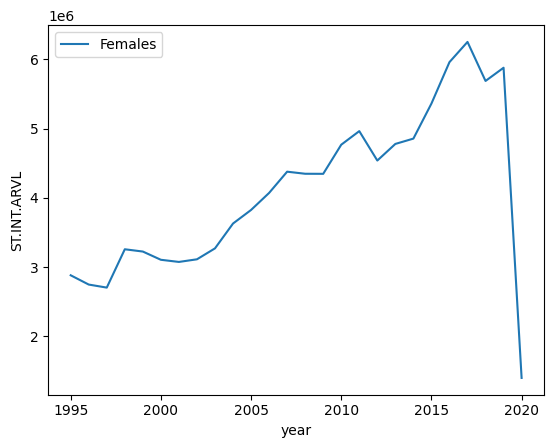

In [28]:
kor = WorldBank()
kor.import_from_world_bank(country_name='South Korea', whole=True)
kor.splice_for_years(1980, 2023)

nor = WorldBank()
nor.import_from_world_bank(country_name='Norway', whole=True)
nor.splice_for_years(1980, 2023)

pan = WorldBank()
pan.import_from_world_bank(country_name='Panama', whole=True)
pan.splice_for_years(1980, 2023)

ind_code = 'ST.INT.ARVL'

kor_data = kor.data
nor_data = nor.data
pan_data = pan.data



#kor_arr_man = eda_inst.data['SE.SEC.CUAT.UP.MA.ZS']

sns.lineplot(data=nor.data, x=nor.data.index, y=ind_code, label='Females')
#sns.lineplot(data=eda_inst.data, x=eda_inst.data.index, y='SE.SEC.CUAT.UP.MA.ZS', label='Men')

plt.show()

In [29]:
#pd.corr(nor_data['ST.INT.ARVL'], nor_data['ST.INT.DPRT'])
nor_data['ST.INT.ARVL'].corr(nor_data['ST.INT.DPRT'])

np.float64(0.8731501420897407)

In [29]:

# add possibility of giving several codes to get_api_data


# NExt mission is to make a forcast method and a method where you can search for specifc combinations 
# of countries and codes and check if the available codes have already been calculated, and where they are stored in a csv

# using sets would be a good method for this

# afterwards, add a method to test for correlation

In [ ]:
# VC.IHR.PSRC.P5	Intentional homicides (per 100,000 people)
# NY.GDP.TOTL.RT.ZS	Total natural resources rents (% of GDP)
# SE.ADT.LITR.ZS	Literacy rate, adult total (% of people ages 15 and above)

# SE.TER.CUAT.DO.FE.ZS	Educational attainment, Doctoral or equivalent, population 25+, female (%) (cumulative)
# SE.TER.CUAT.DO.MA.ZS	Educational attainment, Doctoral or equivalent, population 25+, male (%) (cumulative)

# SE.SEC.CUAT.UP.FE.ZS	Educational attainment, at least completed upper secondary, population 25+, female (%) (cumulative)
# SE.SEC.CUAT.UP.MA.ZS	Educational attainment, at least completed upper secondary, population 25+, male (%) (cumulative)

# ST.INT.ARVL	International tourism, number of arrivals
# ST.INT.DPRT	International tourism, number of departures
